In [150]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Mental rotation

In this notebook we will show how we can enable a pretrained Generative Query Network (GQN) for the Shepard-Metzler mental rotation task. The problem is well studied in psychology to asses spatial intelligence. Mental rotation is a congitive hard problem as it typically requires the employment of both the ventral and dorsal visual streams for recognition and spatial reasoning respectively. Additionally, a certain degree of metacognition is required to reason about uncertainty.

It turns out that the GQN is capable of this, as we will see in this notebook.

<div class="alert alert-block alert-danger">
<strong>Note:</strong>
This model has only been trained on around 20% of the data for $2 \times 10^5$ iterations instead of the $2 \times 10^6$ described in the original paper. This means that the reconstructions are quite bad and the samples are even worse. Consequently, this notebook is just a proof of concept that the model approximately works. If you have the computational means to fully train the model, then please feel free to make a pull request with the trained model, this will help me a lot.
</div>

In [ ]:
import torch
import torch.nn as nn

# Load the model onto CPU and dewrap from dataparallel
model = torch.load("model-final.pt", map_location=lambda storage, _: storage)

if type(model) is nn.DataParallel:
    model = model.module
    
# Load dataset
from shepardmetzler import ShepardMetzler, Scene, transform_viewpoint
from torch.utils.data import DataLoader

dataset = ShepardMetzler("./shepard_metzler_5_parts-torch/train/", target_transform=transform_viewpoint)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

We load a batch of a single image containing a single object seen from 15 different viewpoints. We describe the whole set of image, viewpoint pairs by $\{x_i, v_i \}_{i=1}^{n}$. Whereafter we seperate this set into a context set $\{x_i, v_i \}_{i=1}^{m}$ of $m$ random elements and a query set $\{x^q, v^q \}$, which contains just a single element.

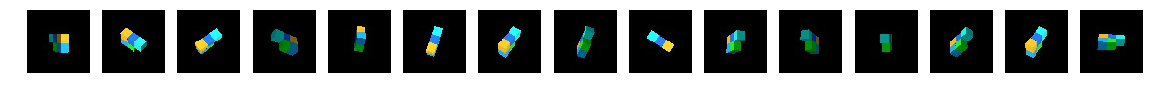

In [152]:
f, axarr = plt.subplots(1, 15, figsize=(20, 7))

x, v = next(iter(loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(x[0][i].permute(1, 2, 0))
    ax.axis("off")

## Reconstruction

Now we feed the whole set into the network and the network will perform the segregration of sets. The query image is then reconstructed in accordance to a given viewpoint and a representation vector that has been generated only by the context set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


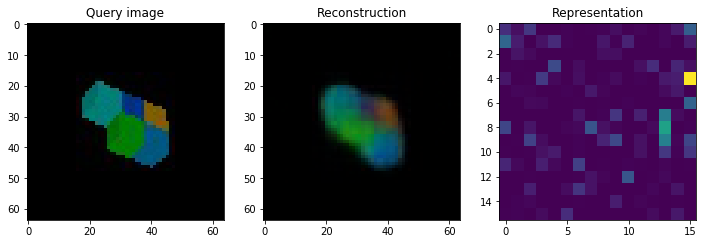

In [153]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 7))

x_mu, x_q, r, _ = model(x, v)

ax1.imshow(x_q[0].data.permute(1, 2, 0))
ax1.set_title("Query image")

ax2.imshow(x_mu[0].data.permute(1, 2, 0))
ax2.set_title("Reconstruction")

ax3.imshow(r.data.view(16, 16))
ax3.set_title("Representation")

plt.show()

## Visualising representation

We might be interested in visualising the representation as more context points are introduced. The representation network $\phi(x_i, v_i)$ generates a single representation for a context point $(x_i, v_i)$ which is then aggregated (summed) for each context point to generate the final representation.

Below, we see how adding more context points creates a less sparse representation.

In [171]:
# Create our own context and query sets
context_x = x[:, :7]
context_v = v[:, :7]

query_v   = v[:, 9]

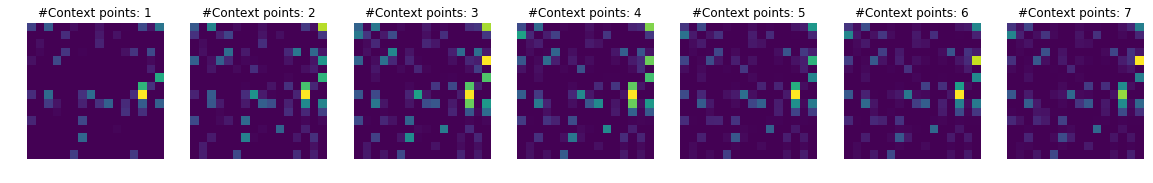

In [155]:
f, axarr = plt.subplots(1, 7, figsize=(20, 7))

r = torch.zeros(1, 256, 1, 1)

for i, ax in enumerate(axarr.flat):
    phi = model.representation(x[:, i], v[:, i])
    r += phi
    ax.imshow(r.data.view(16, 16))
    ax.axis("off")
    ax.set_title("#Context points: {}".format(i+1))

## Sample from the prior.

Because we use a conditional prior density $\pi(z|y)$ that is parametrised by a neural network, we should be able to continuously refine it during training such that if $y = (v, r)$ we can generate a sample from the data distrbution by sampling $z \sim \pi(z|v,r)$ and sending it through the generative model $g_{\theta}(x|z, y)$.

This means that we can give a number of context points along with a query viewpoint and generate a new image.

In [172]:
num_samples = 8

context_x = context_x.repeat(num_samples, 1, 1, 1, 1)
context_v = context_v.repeat(num_samples, 1, 1)

query_v = query_v.repeat(num_samples, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


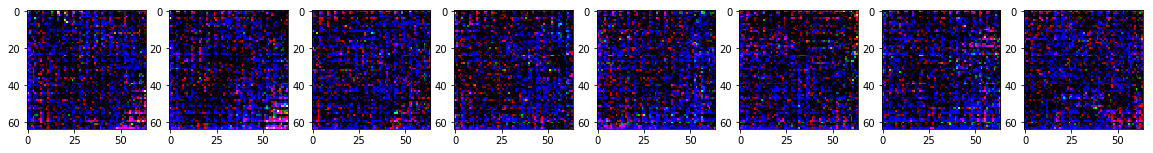

In [174]:
f, axarr = plt.subplots(1, num_samples, figsize=(20, 7))

# Sample images given the same viewpoint and representation
x_samples = model.sample(context_x, context_v, query_v, 0.7)

for i, ax in enumerate(axarr.flat):
    ax.imshow(x_samples[i].data.permute(1, 2, 0))

## Mental rotation task

As an extension to the above mentioned sampling procedure, we can perform the mental rotation task by continuously sampling from the prior given a static representation $r$ and then varying the query viewpoint vector $v^q$ between each sample to "rotate the object".

In the example below we change the yaw slightly at each frame for 8 frames.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


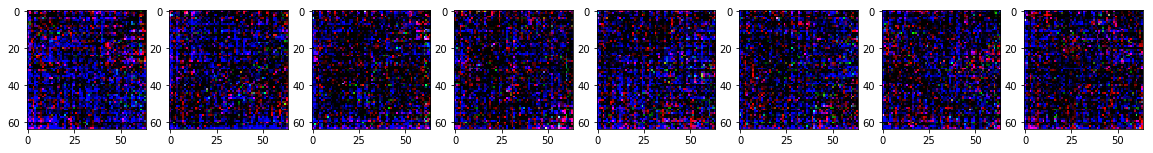

In [180]:
f, axarr = plt.subplots(1, num_samples, figsize=(20, 7))

for i in range(num_samples):
    query_v[i, 3] += np.sin(i/4)

x_samples = model.sample(context_x, context_v, query_v, 7)

for i, ax in enumerate(axarr.flat):
    ax.imshow(x_samples[i].data.permute(1, 2, 0))